In [2]:
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from mpdaf.obj import Image
from astropy.io import fits
from astropy.wcs import WCS
import reproject

sns.set_context("talk")
sns.set_color_codes()

Use the mosaiced image from Castro to define the WCS for reprojection.

In [7]:
mosaic_ha_hdulist = fits.open("../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits")
mosaic_ha_hdulist.info()

Filename: ../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1158   ()      
  1  DATA          1 ImageHDU        52   (650, 650)   float64   
  2  DATA          1 ImageHDU        52   (650, 650)   float64   
  3  DATA          1 ImageHDU        52   (650, 650)   float64   


In [14]:
mosaic_hdr = mosaic_ha_hdulist[1].header

Note that the header still refers to a 3rd dimension, even though this is just an image.  We need to remove all the keywords that mention dimension 3 so that the reprojection will work.

In [15]:
del mosaic_hdr["*3"]
del mosaic_hdr["CD3_*"]

Test with the Hβ image.  First we make an HDU of each field for the full mosaic.

In [30]:
pieces = {}
for field in "ABCD":
    infile = f"../data/lmc-30dor-{field}-hi-4861-bin01-sum.fits"
    hdu = fits.open(infile)["DATA"]
    del hdu.header["*3"]
    del hdu.header["CD3_*"]
    newdata, footprint = reproject.reproject_interp(
        hdu,
        mosaic_hdr,
    )
    pieces[field] = newdata

In [31]:
pieces

{'A': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'B': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'C': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'D': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, n

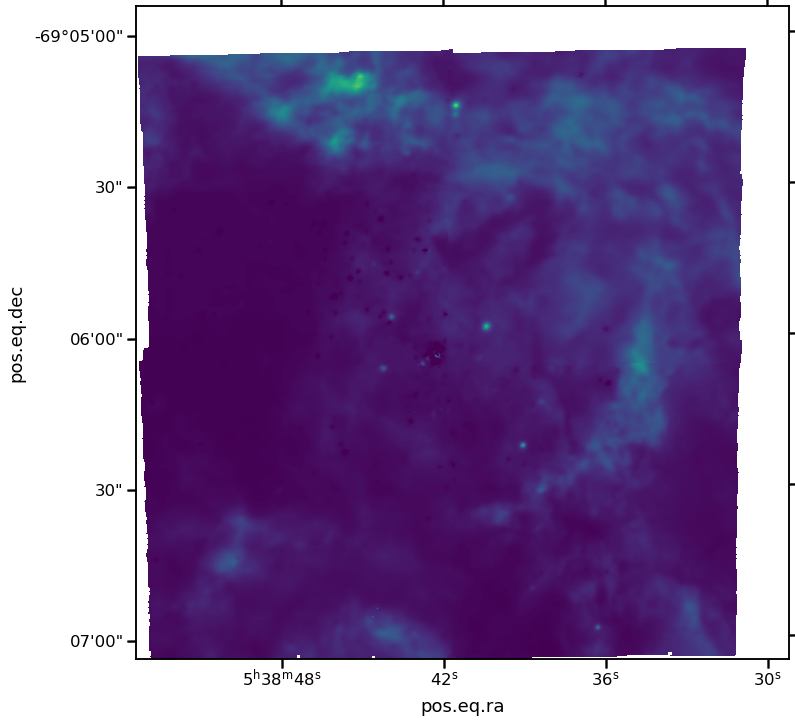

In [32]:
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw=dict(projection=WCS(mosaic_hdr)),
)
ax.imshow(pieces["A"], vmin=0, vmax=1e6)
ax.imshow(pieces["B"], vmin=0, vmax=1e6)
ax.imshow(pieces["C"], vmin=0, vmax=1e6)
ax.imshow(pieces["D"], vmin=0, vmax=1e6)

In [25]:
Image??

Init signature:
Image(
    filename=None,
    ext=None,
    wcs=None,
    data=None,
    var=None,
    unit=Unit(dimensionless),
    copy=True,
    dtype=None,
    **kwargs,
)
Source:        
class Image(ArithmeticMixin, DataArray):

    """Manage image, optionally including a variance and a bad pixel mask.

    Parameters
    ----------
    filename : str
        Possible filename (.fits, .png or .bmp).
    ext : int or (int,int) or string or (string,string)
        Number/name of the data extension or numbers/names
        of the data and variance extensions.
    wcs : `mpdaf.obj.WCS`
        World coordinates.
    unit : str or `astropy.units.Unit`
        The physical units of the data values. Defaults to
        `astropy.units.dimensionless_unscaled`.
    data : float array
        Array containing the pixel values of the image.  None by default.
    var : float array
        Array containing the variance. None by default.
    copy : bool
        If true (default), then the data a

In [20]:
field = "A"
infile = f"../data/lmc-30dor-{field}-hi-4861-bin01-sum.fits"
hdu = fits.open(infile)["DATA"]
del hdu.header["*3"]
del hdu.header["CD3*"]
WCS(hdu.header)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.652917  -69.10944  
CRPIX : 160.35797752799  154.4944582797  
CD1_1 CD1_2  : -5.5555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555556e-05  
NAXIS : 319  321

In [18]:
WCS(mosaic_hdr)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.688309  -69.105970125  
CRPIX : 220.92793852  213.660785628  
CD1_1 CD1_2  : -5.52742276729e-05  -9.66418424553e-08  
CD2_1 CD2_2  : -4.91681964084e-07  5.53153613478e-05  
NAXIS : 650  650

In [5]:
infiles = Path("../data").glob("lmc-30dor-[ABCD]-*bin01-sum.fits")

In [6]:
list(infiles)

[PosixPath('../data/lmc-30dor-B-hi-4861-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-oiii-5007-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ni-5198-5200-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-feiii-4658-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-C-hei-4922-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-B-feiii-5270-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-C-heii-4686-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-ni-5198-5200-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-oii-4650-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-ariv-4740-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-C-feiii-4658-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-A-hi-4861-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-hei-4922-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-ariv-4740-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-B-si-ii-5041-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-oiii-5007-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-D-hi-48